In [2]:

# import zipfile36 as zipfile 
# from zipfile import ZipFile

# #filename = "Data_FER.zip"
# with ZipFile(filename,'r') as zip:
#     zip.extractall(path= "FERdataset")

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input, Dropout, BatchNormalization
from keras_vggface.vggface import VGGFace
import cv2
import numpy as np
import matplotlib as plt
import dlib


detector = dlib.get_frontal_face_detector()
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# rects = detector(gray, 2)
# for rect in rects:
# # extract the ROI of the *original* face, then align the face
# # using facial landmarks
# 	(x, y, w, h) = rect_to_bb(rect)
# 	faceOrig = imutils.resize(image[y:y + h, x:x + w], width=256)
    
# def gray_to_color(img):
#     img = np.array(img, dtype=np.uint8)
#     img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
#     return img

    
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True, preprocessing_function = None)

test_datagen = ImageDataGenerator(rescale=1./255)

#training_path = "FERdataset/Data_FER/Training"

train_generator = train_datagen.flow_from_directory(
    directory= training_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42)

#validation_path = "/content/drive/My Drive/"+my_dir+"/Data_FER/PublicTest"
#validation_path = "FERdataset/Data_FER/PublicTest"

valid_generator = test_datagen.flow_from_directory(
    directory= validation_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42)




In [ ]:
import matplotlib.pyplot as plt
x,y = train_generator.next()
print(x[0].shape)
print(y.shape)
# for i in range(0,1):
#     #image = x[i]
#     image = x[i]
#     print(np.shape(image))
#     plt.figure(figsize=(10,10))
#     plt.imshow(image)



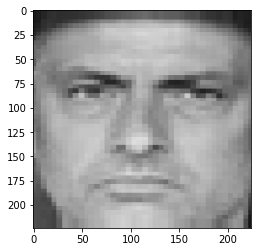

In [9]:
plt.imshow((x[0]*255).astype(np.uint8))

In [ ]:
nb_class = 7
vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
#x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(2048, activation = 'relu', name = 'fc7')(x)
x = BatchNormalization()(x)
#x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
custom_vgg_model = Model(inputs = vgg_model.input, outputs = out)

layer_count = 0
for layer in custom_vgg_model.layers:
    layer_count = layer_count+1
for l in range(layer_count-6): #-3
    custom_vgg_model.layers[l].trainable=False

custom_vgg_model.summary()

for layer in custom_vgg_model.layers:
    print("{}: {}".format(layer, layer.trainable))
 
custom_vgg_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
#keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [ ]:
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow import keras
#from utils.cifar_utils import load_data


epc = 15 #number of epoches
#train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
#train_generator = train_datagen.flow(X_train, Y_train, batch_size=bs)
step_size_train=train_generator.n//train_generator.batch_size
step_size_valid = valid_generator.n//valid_generator.batch_size

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0, callbacks=[es])

history = custom_vgg_model.fit_generator(generator = train_generator,
                   steps_per_epoch = step_size_train,
                   epochs = epc,
                   validation_data=valid_generator,
                   validation_steps = step_size_valid, callbacks = [es])

In [ ]:
#preprocessing model1_10epc_128bs.h5 - normalized (/255), hear_range=0.2, zoom_range=0.2, horizontal_flip=True
#model1_10epc_128bs.h5 is trained with 3 dense layers after the last pooling layer in vgg with 512 (not 4096), (224X224X3 input size) no dropout or batchnorm, optimizer-adam, validation accuracy was ~64% training acc was 86%, loss=0.4 it was overfitting a lot! 
#custom_vgg_model.save_weights('Outputs-FERmodels/model1_10epc_128bs.h5')
#custom_vgg_model.load_weights('Outputs-FERmodels/model1_10epc_128bs.h5')

#model2_10epc_128bs.h5 - normalized,hear_range=0.2, zoom_range=0.2, horizontal_flip=True, 2 dense layers ( fc 6) then Dropout and fc 8 (softmax - 7 classes) - training acc 75%, validation acc = 66.5 %  loss = 0.66
#custom_vgg_model.save_weights('Outputs-FERmodels/model2_10epc_128bs.h5')

#model3_15epc_128bs.h5  dropout+ trained on 15 epochs
#custom_vgg_model.save_weights('Outputs-FERmodels/model3_15epc_128bs.h5')

#custom_vgg_model.save_weights('Outputs-FERmodels/model4_25epc_128bsEs.h5') - 87% train acc, val acc 65%
#custom_vgg_model.save_weights('Outputs-FERmodels/model5_15epc_128bsEs.h5') - 86% train acc, val acc 65%


#Most recent model 
# model 6 - after the flatten layer - 
# x = Dense(4096, activation='relu', name='fc6')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
# x = Dense(2048, activation = 'relu', name = 'fc7')(x)
# x = BatchNormalization()(x)
#custom_vgg_model.save_weights('Outputs-FERmodels/model6_15epc_64bsEs.h5') 
#70.5% train acc, val acc 64.2%




In [ ]:
# custom_vgg_model.save('custom_vgg_model.h5')

custom_vgg_model.save('custom_vgg_model6.h5')
# custom_vgg_model = keras.models.load_model('custom_vgg_model.h5', compile = False)
# custom_vgg_model.summary()

In [ ]:
#custom_vgg_model.save('custom_vgg_model1.h5')
custom_vgg_model = keras.models.load_model('custom_vgg_model6.h5', compile = False)
custom_vgg_model.summary()

In [ ]:
import keras
x,y = train_generator.next()
new_model = keras.models.load_model('custom_vgg_model6.h5')
new_model.layers.pop()
new_model = Model(inputs=new_model.inputs, outputs=new_model.layers[-1].output)
new_model.summary()


In [ ]:
print(x.shape)
def process_frame(queue):
    batchImages = np.stack(queue)
    #print(np.shape(batchImages))
    features = new_model.predict(batchImages)
    #print(np.shape(features))
    return features

process_frame(x)

In [ ]:
#custom_vgg_model.load_weights('Outputs-FERmodels/model2_10epc_128bs.h5')
import matplotlib.pyplot as plt
%matplotlib inline
#print(f'Baseline accuracy: {custom_vgg_model.evaluate(X_valid, Y_valid)[1]}')

print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()